In [34]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
data = pd.read_csv("ICU.csv", index_col= 0)
data.index -= 1
data

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1
...,...,...,...,...,...,...,...,...,...
195,921,0,50,2,1,0,256,64,1
196,923,1,20,1,0,0,104,83,1
197,924,1,73,3,1,0,162,100,1
198,925,1,59,2,0,0,100,88,1


Eventual goal is to predict a patient's survival rate, so 'Survival' feature will be our response.

# EDA

In [36]:
data.isnull().values.any()

False

In [37]:
max(data['Age']), min(data['Age'])

(92, 16)

No issues with ages, since 92 is a reasonable maximum age within a group of 200 patients, and there are no negative values

In [38]:
data['AgeGroup'].value_counts()

2    77
3    64
1    59
Name: AgeGroup, dtype: int64

In [39]:
data['Sex'].value_counts()

0    124
1     76
Name: Sex, dtype: int64

In [40]:
data['Infection'].value_counts()

0    116
1     84
Name: Infection, dtype: int64

In [41]:
data['Emergency'].value_counts()

1    147
0     53
Name: Emergency, dtype: int64

In [42]:
data['Survive'].value_counts()

1    160
0     40
Name: Survive, dtype: int64

## Systolic Blood Pressure
SysBP likely refers to Systolic Blood Pressure. From a quick Google search, I get the following groups which shall serve as bins for the plot for this feature  :

1. Healthy : < 120
2. Elevated : 120 - 129
3. Stage 1 Hypertension : 130 - 139
4. Stage 2 Hypertension : 140 - 179
5. Hypertension crisis : 180 or higher

In [43]:
min(data['SysBP']), max(data['SysBP'])

(36, 256)

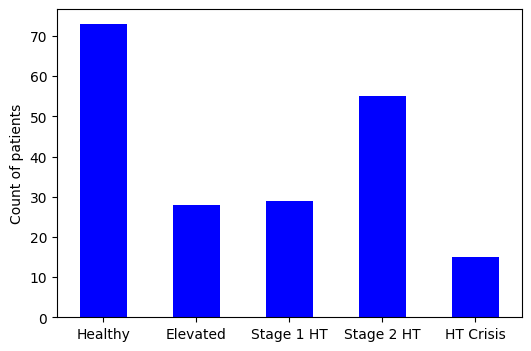

In [44]:
import matplotlib.pyplot as plt
#bins = [[0,119],[120, 129],[130, 139], [140, 179], [180, max(data['SysBP'])]]
out = pd.cut(data['SysBP'], bins=[0, 120, 130, 140, 180, max(data['SysBP'])], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels(['Healthy','Elevated','Stage 1 HT','Stage 2 HT','HT Crisis'])
plt.ylabel('Count of patients')
plt.show()

<Axes: xlabel='SysBP'>

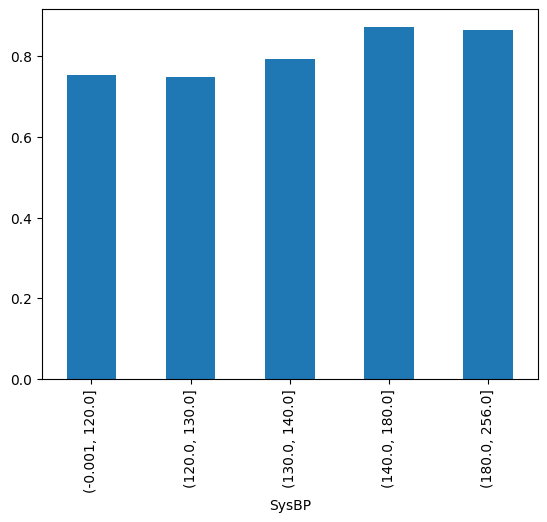

In [45]:
# take the average survival rate of each of the groups)
pd.concat([out, data['Survive']], axis = 1).groupby(['SysBP'])['Survive'].mean().plot.bar()

Quite incredibly, higher BP seems to point to higher survial rate. The only 2 possible reasons for this would be either 1 in Survive indicates death, or my assumption of higher B.P likely resulting in death is completely false. 

I shall check this against the pulse category.

## Pulse

Again, with a quick Google search, a normal pulse would be 60 - 100.

I will convert the pulse rates to a binary feature Normal_Pulse, 1 inidicating the pulse falls between 60 and 100, 0 otherwise.

In [46]:
import numpy as np
data['Normal Pulse'] = np.where((data['Pulse'] >= 60) & (data['Pulse'] <= 100),1, 0)
data

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency,Normal Pulse
0,4,0,87,3,1,1,80,96,1,1
1,8,1,27,1,1,1,142,88,1,1
2,12,1,59,2,0,0,112,80,1,1
3,14,1,77,3,0,0,100,70,0,1
4,27,0,76,3,1,1,128,90,1,1
...,...,...,...,...,...,...,...,...,...,...
195,921,0,50,2,1,0,256,64,1,1
196,923,1,20,1,0,0,104,83,1,1
197,924,1,73,3,1,0,162,100,1,1
198,925,1,59,2,0,0,100,88,1,1


In [47]:
data[['Survive','Normal Pulse']].groupby(['Normal Pulse'])['Survive'].mean()

Normal Pulse
0    0.797753
1    0.801802
Name: Survive, dtype: float64

There is negligible difference between the survival rates in the 2 groups. Let's just continue assuming Survive = 1 means the patient survived, and that my assumption regarding SysBP was wrong.

# Data Preprocessing

## Scaling Data

Remove the ID,AgeGroup and Normal Pulse features. 
ID will not be useful in prediction
AgeGroup and Normal Pulse aren't exactly needed as we already have the patients' ages and pulse rates

In [49]:
data = data.drop(columns = ['ID','AgeGroup','Normal Pulse'])
data

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
0,0,87,1,1,80,96,1
1,1,27,1,1,142,88,1
2,1,59,0,0,112,80,1
3,1,77,0,0,100,70,0
4,0,76,1,1,128,90,1
...,...,...,...,...,...,...,...
195,0,50,1,0,256,64,1
196,1,20,0,0,104,83,1
197,1,73,1,0,162,100,1
198,1,59,0,0,100,88,1


Next step would be to normalize the data, specifically the Age, SysBP and Pulse columns

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(data[['Age','SysBP','Pulse']]))
scaled_df = pd.DataFrame(scaler.transform(pd.DataFrame(data[['Age','SysBP','Pulse']])), columns = ('Age','SysBP','Pulse'))
scaled_df


,Age,SysBP,Pulse
0,0.934211,0.200000,0.372549
1,0.144737,0.481818,0.320261
2,0.565789,0.345455,0.267974
3,0.802632,0.290909,0.202614
4,0.789474,0.418182,0.333333
...,...,...,...
195,0.447368,1.000000,0.163399
196,0.052632,0.309091,0.287582
197,0.750000,0.572727,0.398693
198,0.565789,0.290909,0.320261


In [63]:
data['Age'] = scaled_df['Age']
data['SysBP'] = scaled_df['SysBP']
data['Pulse'] = scaled_df['Pulse']
data

,Survive,Age,Sex,Infection,SysBP,Pulse,Emergency
0,0,0.934211,1,1,0.200000,0.372549,1
1,1,0.144737,1,1,0.481818,0.320261,1
2,1,0.565789,0,0,0.345455,0.267974,1
3,1,0.802632,0,0,0.290909,0.202614,0
4,0,0.789474,1,1,0.418182,0.333333,1
...,...,...,...,...,...,...,...
195,0,0.447368,1,0,1.000000,0.163399,1
196,1,0.052632,0,0,0.309091,0.287582,1
197,1,0.750000,1,0,0.572727,0.398693,1
198,1,0.565789,0,0,0.290909,0.320261,1


## SMOTE sampling

In [65]:
X = data[['Age','Sex','Infection','SysBP','Pulse','Emergency']]
y = data['Survive']

In [69]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=888)
X_res, y_res = sm.fit_resample(X,y)
sum(y_res)/len(y_res)

0.5

## Train - Test split

In [71]:
final_df = pd.concat([X_res, y_res], axis = 1)
final_df 

,Age,Sex,Infection,SysBP,Pulse,Emergency,Survive
0,0.934211,1,1,0.200000,0.372549,1,0
1,0.144737,1,1,0.481818,0.320261,1,1
2,0.565789,0,0,0.345455,0.267974,1,1
3,0.802632,0,0,0.290909,0.202614,0,1
4,0.789474,1,1,0.418182,0.333333,1,0
...,...,...,...,...,...,...,...
315,0.831888,0,1,0.433390,0.614240,1,0
316,0.759870,0,0,0.470451,0.611113,0,0
317,0.825548,0,0,0.280509,0.297663,1,0
318,0.514661,0,1,0.387793,0.407654,1,0


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 888)

# Machine Learning

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
logreg = LogisticRegression(random_state=888).fit(X_train, y_train)

### Test Results

In [83]:
logreg_preds_test = logreg.predict(X_test)

In [84]:
print("Test Accuracy : {}".format(accuracy_score(logreg_preds_test, y_test)))
print("Test Recall : {}".format(recall_score(logreg_preds_test, y_test)))
print("Test Precision : {}".format(precision_score(logreg_preds_test, y_test)))
print("Test F1 Score : {}".format(f1_score(logreg_preds_test, y_test)))

Training Accuracy : 0.78125
Training Recall : 0.9259259259259259
Training Precision : 0.6756756756756757
Training F1 Score : 0.7812500000000001


## Decision Tree

In [85]:
from sklearn.tree import DecisionTreeClassifier

In [92]:
decision_tree = DecisionTreeClassifier(random_state=888).fit(X_train, y_train)

### Test Results

In [98]:
dt_preds_test = decision_tree.predict(X_test)

In [99]:
print("Test Accuracy : {}".format(accuracy_score(dt_preds_test, y_test)))
print("Test Recall : {}".format(recall_score(dt_preds_test, y_test)))
print("Test Precision : {}".format(precision_score(dt_preds_test, y_test)))
print("Test F1 Score : {}".format(f1_score(dt_preds_test, y_test)))

Test Accuracy : 0.703125
Test Recall : 0.7142857142857143
Test Precision : 0.8108108108108109
Test F1 Score : 0.759493670886076


## Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
random_forest = RandomForestClassifier(random_state=888).fit(X_train, y_train)

### Test Results

In [102]:
rf_preds_test = random_forest.predict(X_test)

In [103]:
print("Test Accuracy : {}".format(accuracy_score(rf_preds_test, y_test)))
print("Test Recall : {}".format(recall_score(rf_preds_test, y_test)))
print("Test Precision : {}".format(precision_score(rf_preds_test, y_test)))
print("Test F1 Score : {}".format(f1_score(rf_preds_test, y_test)))

Test Accuracy : 0.828125
Test Recall : 0.9333333333333333
Test Precision : 0.7567567567567568
Test F1 Score : 0.835820895522388


# Final Model